In [ ]:
#!pip install line_profiler
#%load_ext line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 8.7 MB/s eta 0:00:00


In [1]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker
import numpy as np
import math
import datetime as dt

In [ ]:
maxX=500;
maxY=500;

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#LoRa settings
Ptx = 14
gamma = 2.08
d0 = 40.0
var = 0
Lpld0 = 127.41
GL = 0

sf7 = np.array([7,-123,-120,-116])
sf8 = np.array([8,-126,-123,-119])
sf9 = np.array([9,-129,-125,-122])
sf10 = np.array([10,-132,-128,-125])
sf11 = np.array([11,-134.5,-130,-128])
sf12 = np.array([12,-137,-133,-130])
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])
minsensi = -112.0
Lpl = Ptx - minsensi

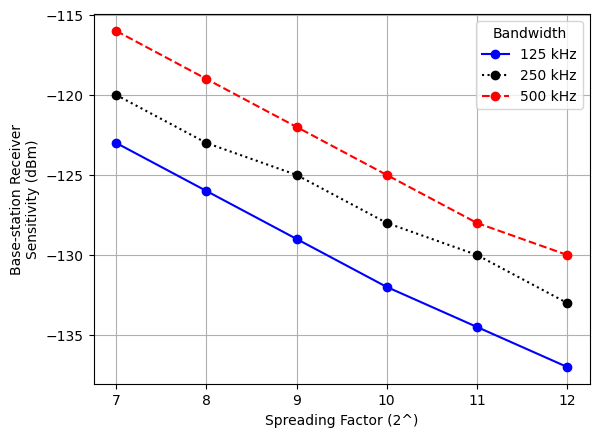

[[137.  134.  130. ]
 [140.  137.  133. ]
 [143.  139.  136. ]
 [146.  142.  139. ]
 [148.5 144.  142. ]
 [151.  147.  144. ]]
[[ 63.43001337  54.9105983   45.30415204]
 [ 73.27122124  63.43001337  52.33312073]
 [ 84.63929891  69.83190469  60.45263848]
 [ 97.77114124  80.66637016  69.83190469]
 [110.25785531  88.80789982  80.66637016]
 [124.33929383 102.58650329  88.80789982]]
63.43001336951186


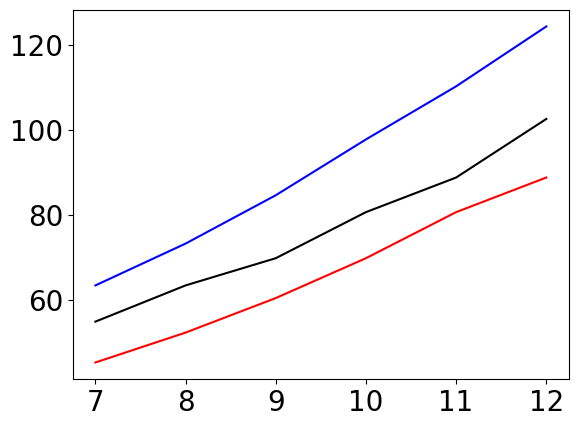

In [ ]:
# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")
    #print(sensi[:,1])

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")
    plt.xticks([7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()

plotSensitivity(sensi)

# node placement
Lpl_matrix = Ptx - (sensi[:,1:])
print(Lpl_matrix)
maxDist = np.dot(d0, np.exp(np.divide((Lpl_matrix - Lpld0),(10*gamma))))
print(maxDist)
print(d0*(math.e**((Lpl_matrix[0,0]-Lpld0)/(10.0*gamma))))
bestDist = np.amin(maxDist)

def plotMaxDistFig():
    maxDist_fig = plt.figure()
    plt.plot(sensi[:,0], maxDist[:,0], 'b', label="125 kHz")
    plt.plot(sensi[:,0], maxDist[:,1], 'k', label="250 kHz")
    plt.plot(sensi[:,0], maxDist[:,2], 'r', label="500 kHz")
    plt.xticks([7,8,9,10,11,12])
    plt.show()

plotMaxDistFig()


In [2]:
#
# this function creates a BS
#
class myBS:
    def __init__(self, id, position):
        self.id = id
        self.x, self.y = position
        self.packet = [];

#
# this function creates a node
#
class myNode:
    def __init__(self, id, position = (1,1), period = 20000):
        self.id = id
        self.x, self.y = position
        self.period = period
        self.dist = []
        self.freq = 868.3
        self.packetlen = 50
        self.packet = [];
        self.bw = 125
        self.sf = 12
        self.cr = 1
        self.sent = 0
        self.delivered = 0
        self.total_airtime = 0

    def getTransmissionParams(self):
        # this function currently returns fixed parameters

        return self.freq, self.bw, self.sf, self.cr

    def updateSF(self, sf):
      self.sf = sf

    def updatePos(self, position):
      self.x, self.y = position

    def updateDist(self, bsList):
      self.dist = []
      for b in bsList:
        d = math.sqrt((self.x-b.x)*(self.x-b.x)+(self.y-b.y)*(self.y-b.y))
        self.dist.append(d)
        #magicPacket=myPacket(self.id, self.packetlen, d, self.freq, b.id, self.sf, self.cr, self.bw)
        #b.packet.append(magicPacket)
        #self.packet.append(magicPacket)


#
# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket:

    def toString(self):
      return "Packet - Node:" + str(self.node) + " BS: " + str(self.bs) + " SF: " + str(self.sf)

    def __init__(self, node, plen, distance, freq, bs, sf, cr, bw):
        global Ptx
        global gamma
        global d0
        global Lpld0
        global GL
        #global sensi


        # new: base station ID
        self.bs = bs
        self.node = node
        self.txpow = Ptx

        # randomize configuration values
        self.sf = sf
        self.cr = cr
        self.bw = bw

        # log-shadow
        # note: transmit power is global variable
        if distance == 0:
          distance = 0.00001
        Lpl = Lpld0 + 10*gamma*math.log10(distance/d0)
#         print Lpl
        Prx = Ptx - GL - Lpl

        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = plen
        self.symTime = (2**self.sf)/self.bw
        #self.arriveTime = 0
        self.rssi = Prx
        self.freq = freq
        self.addTime = None
        self.rectime = dt.timedelta(milliseconds = airtime(self))
        # denote if packet is collided
        self.collided = False
        #self.processed = 0
        self.lost = False
        #packet_sensitivity = sensi[sf - 7, int(bw // 250) + 1]
        #self.lost = self.rssi < packet_sensitivity
        #if self.lost:
        #     print ("node {} bs {} lost (rssi = {} < sensi = {})".format(self.nodeid, self.bs, self.rssi, packet_sensitivity))



In [ ]:
'''Se non trasmetto reward = 0
Calcolo del reward per ogni singolo agente indipendentemente dagli altri.
Normalizzare tempo in aria (Toa-Toa_min)/(Toa_max - Toa_,min)'''

'Se non trasmetto reward = 0\nCalcolo del reward per ogni singolo agente indipendentemente dagli altri.\nNormalizzare tempo in aria (Toa-Toa_min)/(Toa_max - Toa_,min)'

In [ ]:
class LoRaNetwork(gym.Env):

  def __init__(self, max_steps= 100, n_agents=100, n_threshold = 6, period=12000, loc_range = min(maxX,maxY), tx_prob = 0.99, beta = 0.25):
    #self.observations = ['id', 'distance', 'sf', 'collided']
    self.n_agents = n_agents;
    self.beta = beta;
    self.loc_range = loc_range;
    self.tx_prob = tx_prob;
    self.bsList = [];
    self.n_bs = 1;
    self.bs = myBS
    self.period = period
    self._max_steps = max_steps
    self._total_episode_reward = None
    self._step_count = None
    self._agent_dones = None
    self.agents = [];
    self.full_threshold = False
    self._bs_map = np.zeros((self.n_bs, 3))
    self._nodes_map = np.zeros((self.n_agents, 3))
    self.medium=1/float(2*self.n_agents)
    self.high=1/float(self.n_agents)
    self._n_threshold = n_threshold
    n=1
    if self._n_threshold > self.n_agents:
      self.full_threshold = True
    elif self.n_agents >=  2*self._n_threshold:
      n=2.5
    self.thresholds = list(round(i*self.n_agents/(n)/self._n_threshold) for i in range(n_threshold))
    self.arr_thresholds = np.array(self.thresholds)
    if self.n_agents/(5)/self._n_threshold < 1:
        self.arr_thresholds_high = np.arange(stop=self._n_threshold, step=1)
    else:
        self.arr_thresholds_high= np.arange(stop=self.n_agents/(5), step = math.ceil(self.n_agents/(5)/self._n_threshold))[:self._n_threshold]
    #self.action_space = spaces.Discrete(6)
    self.colors = ['red', 'blue', 'green', 'yellow', 'purple', 'pink']
    self.action_space = spaces.MultiDiscrete(self.n_agents*[6])
    self.datetime = None
    #self.observation_space = spaces.Dict({"id": spaces.Box(low=0, shape=()), "distance": spaces.Box(1), "sf": spaces.Discrete(len(SF)), "collision": spaces.Discrete(2)})
    self.observation_space = self.make_obs_space()
    self.packetsAtBS = []
    self.full_collision = True
    self.step_date = None
    self.max_air_time = airtime(myPacket(1, 50, 1, 868.3, 1, 12, 1, 125))
    self.min_air_time = airtime(myPacket(2, 50, 1, 868.3, 1, 7, 1, 125))

  def make_obs_space(self):
    return gym.spaces.MultiDiscrete(6*[self._n_threshold])

  '''def observation(self):
    SF_obs = np.zeros(6, dtype=np.int8)
    for agent in self.agents:
      SF_obs[agent.sf - 7] +=1
    #print(SF_obs)
    SF_obs_r = np.zeros(6, dtype=np.int8)
    SF_obs_r[(SF_obs>self.medium)&(SF_obs<self.high)] = 1
    SF_obs_r[(SF_obs>=self.high)] = 2
    return SF_obs_r'''

  def get_threshold_level(self, n, SF):
    if(SF<=3):
      return sum(l<=n for l in self.arr_thresholds)-1
    else:
      return sum(l<=n for l in self.arr_thresholds_high)-1

  def observation(self):
    SF_obs = np.zeros(6, dtype=np.int8)
    #SF_obs_r = np.zeros(6, dtype=np.int8)
    SF_obs_t = np.zeros(6, dtype=np.int8)
    for agent in self.agents:
      SF_obs[agent.sf - 7] +=1
    if self.full_threshold:
      return SF_obs
    for i in range(6):
      SF_obs_t[i] = self.get_threshold_level(SF_obs[i],i)
    #for i in range(1,self._n_threshold):
      #print("i: ", i," low: ", self.thresholds[i-1], " high:", self.thresholds[i])
      #SF_obs_r[(SF_obs>=self.thresholds[i-1])&(SF_obs<self.thresholds[i])] = i-1
    #SF_obs_r[(SF_obs>=self.thresholds[-1])] = self._n_threshold-1
    #print("SF_obs_t: {}, SF_obs_r: {}".format(SF_obs_t, SF_obs_r))
    return SF_obs_t

  def reset(self, seed = None, options = None):
    # We need the following line to seed self.np_random
    super().reset(seed=seed)
    #print(f'env.np_random {env._np_random=}')
    #print(f'env.seed np_random state: {env._np_random.bit_generator.state}')
    self.agents.clear()
    self.bsList.clear()
    self.datetime = dt.datetime.now();
    self.bsList.append(myBS(id=0, position = (0, 0)));
    self._step_count = 0
    t = self.np_random.uniform(0, 1, size=self.n_agents)
    u = self.np_random.uniform(0, 1, size=self.n_agents)
    x = self.loc_range*np.sqrt(t) * np.cos(2*np.pi*u)
    y = self.loc_range*np.sqrt(t) * np.sin(2*np.pi*u)
    for i in range(self.n_agents):
      agent = myNode(id=i, period=self.period)
      agent.updatePos((x[i],y[i]))
      #agent.updateSF(self.np_random.randint(7,12))
      agent.updateSF(7)
      agent.updateDist(self.bsList)
      self.agents.append(agent)
    return self.observation()

  def render(self, plot = False, last_step_only = True):
    pdr = []
    if plot:
      fmt = matplotlib.dates.DateFormatter('%M:%S.%f')
      plt.figure(figsize=(30,15))
      ax=plt.axes();
      ax.xaxis.set_major_formatter(fmt)
      plt.rcParams.update({'ytick.labelsize':'x-small','xtick.labelsize':'x-small'})
      ax.set_ylim(-0.5, self.n_agents - 0.5)
      ax.set_xlabel('Time')
      ax.set_ylabel('Agent ID')
      if last_step_only:
        ax.set_xlim(matplotlib.dates.date2num(self.datetime), matplotlib.dates.date2num(self.datetime + dt.timedelta(milliseconds=self.period)))
      else:
        plt.locator_params(axis='x', nbins=self._step_count)
        ax.set_xlim(matplotlib.dates.date2num(self.datetime - self._step_count*dt.timedelta(self.period)), matplotlib.dates.date2num(self.datetime + dt.timedelta(self.period)))
      #ax.xaxis.set_major_locator(matplotlib.dates.SecondLocator(bysecond=100))
      ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
      plt.grid(True)
      plt.title('Pacchetti')
    for agent in self.agents:
      addtimes = []
      rectimes = []
      print("Node ID: {:02d}".format(agent.id), " SF: {:02d} ".format(agent.sf), " packets sent: ", agent.sent, " packets received: ", agent.delivered, " PDR:'{0:.2f}'".format(agent.delivered/agent.sent))
      pdr.append(agent.delivered/agent.sent)
      for packet in agent.packet:
        if plot:
          addtime = matplotlib.dates.date2num(packet.addTime)
          addtimes.append(addtime)
          rectime = matplotlib.dates.date2num(packet.addTime + packet.rectime)
          rectimes.append(rectime)
          plt.hlines(agent.id, xmin=addtime, xmax=rectime, label="SF{:02d}".format(packet.sf), color=self.colors[packet.sf - 7], lw=5, linestyle = 'dotted' if packet.collided else 'solid')
          if last_step_only:
            addtimes = addtimes[-10:]
            rectimes = rectimes[-10:]
          #print(len(addtimes))
          #print(len(rectimes))
          #print("agent: ", packet.node ," p sf:", packet.sf, " p distance: ", agent.dist[packet.bs]," addtime: ", packet.addTime, " p rectime:", packet.addTime + packet.rectime, "p airtime:", packet.rectime)
          #y = np.full([len(addtimes)], agent.id)
          #plt.hlines(y, xmin=np.array(addtimes), xmax=np.array(rectimes), color='r')
    if plot:
      plt.legend()
      legend_without_duplicate_labels(ax)
      plt.show()
    print("Average PDR: {0:.2f}".format(np.array(pdr).sum()/len(pdr)))

  def transmit(self,node):
        node.sent = node.sent + 1
        packet = myPacket(node.id, node.packetlen, node.dist[0], node.freq, 0, node.sf, node.cr, node.bw)
        node.total_airtime += packet.rectime.total_seconds()*1000
        sensitivity = sensi[packet.sf - 7, [125,250,500].index(packet.bw) + 1]
        time_change = dt.timedelta(milliseconds=np.random.uniform(0,node.period,None))
        packet.addTime = self.datetime + time_change
        if packet.rssi < sensitivity:
                print("node {}: packet will be lost".format(node.id))
                packet.lost = True
        else:
                    packet.lost = False
                    self.bsList[packet.bs].packet.append(packet)
        node.packet.append(packet)

  def calculate_reward(self,node):
    if node.sent == 0:
      return 0
    a = 1
    b = self.beta
    sent = 0
    delivered = 0
    n_airtime = 0
    #print("Totale pacchetti ", len(node.packet))
    #print("Ultimo pacchetto ", (airtime(node.packet[-1])- self.min_air_time)/(self.max_air_time - self.min_air_time))
    #print("Somma ",sum((airtime(packet) - self.min_air_time)/(self.max_air_time - self.min_air_time) for packet in node.packet)/len(node.packet))
    #for packet in node.packet[-5:]:
    #  sent += 1
    #  n_airtime += packet.rectime.total_seconds()*1000
    #  if packet.collided == False and not packet.lost :
    #    delivered += 1
    #reward =  delivered/sent - b * (n_airtime/sent - self.min_air_time)/(self.max_air_time - self.min_air_time)
    reward = node.delivered/node.sent - b * (airtime(node.packet[-1]) - self.min_air_time)/(self.max_air_time - self.min_air_time)
    return reward

  def step(self, action):
    sent = 0
    delivered = 0
    total_airtime = 0
    reward = np.zeros(self.n_agents)
    pdr = np.zeros(self.n_agents)
    agents_id=set()
    self._step_count +=1
    self.datetime = self.datetime + dt.timedelta(milliseconds=100000)
    done = (self._step_count >= self._max_steps)
    for i, agent in enumerate(self.agents):
      #if abs(np.random.normal(loc=0.0, scale=1.0, size=None))> 1:
      if self.np_random.random()<self.tx_prob:
        agents_id.add(agent.id)
        agent.updateSF(action[i] + 7)
        #agent.updateDist(self.bsList)
        #print("New agent id: ", agent.id, "SF: ", agent.sf)
        self.transmit(agent)
        sent +=1
        #print("Node ", agent.id, "packet sent: ",agent.sent)
    for b in self.bsList:
      #print("Original lenght", len(b.packet))
      b.packet.sort(key=lambda x: x.addTime)
      for p in range(len(b.packet)):
        packet = b.packet.pop()
        total_airtime += packet.rectime.total_seconds()*1000
        if not packet.collided and not packet.lost:
          if (self.checkcollision(packet)==1):
                          packet.collided = True
          else:
                          delivered +=1
                          self.agents[packet.node].delivered +=1
                          #print(self.agents[packet.node].delivered)
      #print("New len:", len(b.packet))
      b.packet = []
    for id in agents_id:
      reward[id] = self.calculate_reward(self.agents[id])
      pdr[id] = self.agents[id].delivered/self.agents[id].sent
    #reward += sum(self.calculate_reward(self.agents[id]) for id in agents_id)
    #reward = delivered/sent - self.beta * (total_airtime/sent - self.min_air_time)/(self.max_air_time - self.min_air_time)
    '''if agents_id:
      reward = reward/len(agents_id)
    else:
      reward = 0'''
    avg_airtime = total_airtime/sent
    info = {'pdr': pdr.mean(), 'avg_airtime': avg_airtime, 'del_factor': delivered/total_airtime}
    return self.observation(), reward, done, info

      # collision checks using the independent interference model
  # the collision functions are heavily dependent on the object definitions

  #
  # check for collisions at base station
  # Note: called before a packet (or rather node) is inserted into the list
  #
  # conditions for collions:
  #     1. same sf
  #     2. frequency
  def checkcollision(self, packet):
      col = False # flag needed since there might be several collisions for packet
      # lost packets don't collide
      if packet.lost:
          return col
      for other in self.bsList[packet.bs].packet:
              #print(len(self.bsList[packet.bs].packet))
              if other.node != packet.node:
                  # simple collision
                if frequencyCollision(packet, other) and sfCollision(packet, other):
                    if self.full_collision:

                        if timingCollision(packet, other):
                              # check who collides in the power domain
                              #c = powerCollision(packet, other)
                              # mark all the collided packets
                              # either this one, the other one, or both
                              #for p in c:
                              #p.collided = 1
                              #print("---TIMING COLLISION---")
                              #print("agent: ", packet.node ," p sf:", packet.sf, " addtime: ", packet.addTime, " p rectime:", packet.addTime + packet.rectime, "p airtime:", packet.rectime)
                              #print("agent: ", other.node ," p sf:", other.sf, " addtime: ", other.addTime, " p rectime:", other.addTime + other.rectime, "p airtime:", other.rectime)
                              col = True
                              other.collided = True
                    else:
                          other.collided = True
                          col = True
                #else:
                          #print("No collision")
      return col

In [ ]:
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
  if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
      return True
  elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
      return True
  else:
      if (abs(p1.freq-p2.freq)<=30):
          return True
  return False

def sfCollision(p1, p2):
  if p1.sf == p2.sf:
      # p2 may have been lost too, will be marked by other checks
      return True
  return False

def powerCollision(p1, p2):
  powerThreshold = 6 # dB
  if abs(p1.rssi - p2.rssi) < powerThreshold:
      # packets are too close to each other, both collide
      # return both packets as casualties
      return (p1, p2)
  elif p1.rssi - p2.rssi < powerThreshold:
      # p2 overpowered p1, return p1 as casualty
      return (p1,)
  # p2 was the weaker packet, return it as a casualty
  return (p2,)

def timingCollision(p1, p2):
  # assuming p1 is the freshly arrived packet and this is the last check
  # we've already determined that p1 is a weak packet, so the only
  # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

  # assuming 8 preamble symbols
  Npream = 8

  # check whether p2 ends in p1's critical section
  if(p1.addTime > p2.addTime):
    Tpreamb = p1.symTime * (Npream - 5)
    p2_end = p2.addTime + p2.rectime
    p1_cs = p1.addTime + dt.timedelta(milliseconds=Tpreamb)
  else:
    Tpreamb = p2.symTime * (Npream - 5)
    p2_end = p1.addTime + p1.rectime
    p1_cs = p2.addTime + dt.timedelta(milliseconds=Tpreamb)

  if p1_cs < p2_end:
      # p1 collided with p2 and lost
      return True
  return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(packet):
  H = 0        # implicit header disabled (H=0) or not (H=1)
  DE = 0       # low data rate optimization enabled (=1) or not (=0)
  Npream = 8   # number of preamble symbol (12.25  from Utz paper)

  if packet.bw == 125 and packet.sf in [11, 12]:
      # low data rate optimization mandated for BW125 with SF11 and SF12
      DE = 1
  #if packet.sf == 6:
      # can only have implicit header with SF6
      #H = 1

  Tsym = packet.symTime
  Tpream = (Npream + 4.25)*Tsym
  payloadSymbNB = 8 + max(math.ceil((8.0*packet.pl-4.0*packet.sf+28+16-20*H)/(4.0*(packet.sf-2*DE)))*(packet.cr+4),0)
  Tpayload = payloadSymbNB * Tsym
  return Tpream + Tpayload



In [ ]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    return ax


def plotLocations(BSLoc, nodeLoc):
    loc_plot = plt.figure(figsize = (10,10))
    loc_ax = plt.gca()

    for b in BSLoc:
        loc_ax.add_artist(plt.Circle((b.x, b.y), bestDist, fill=False, hatch='//', color = 'red'))
        bsPoints = plt.plot(b.x, b.y, "r^", label="Gateway")

    for n in nodeLoc:
      plt.plot(n.x, n.y, "b.", mfc='none', label="End Device")


    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend_without_duplicate_labels(loc_ax)
    plt.grid()

    plt.axis('equal')
    plt.xlim((-maxX/2-10, maxX/2+10))
    plt.ylim((-maxY/2-10, maxY/2+10))

    plt.xlabel('distance (m)')
    plt.ylabel('distance (m)')
    plt.xticks([-maxX/2, -maxX/4, 0, maxX/4, maxX/2], [-maxX/2,-maxX/4,0,maxX/4,maxX/2])
    plt.yticks([-maxY/2, -maxY/4, 0, maxY/4, maxY/2], [-maxY/2,-maxY/4,0,maxY/4,maxY/2])
    plt.show()

In [ ]:
def get_state_idx(state):
  return sum(state[i]*n_threshold**(i) for i in range(len(state)))

In [ ]:
def get_action_idx(action):
  return sum(action[i]*6**(i) for i in range(len(action)))

In [ ]:
#Setting the hyperparameters

lr = 0.1
initial_lr=lr
discount_factor = 0.9
epsilon = 1
max_epsilon = 1
min_epsilon = 0.1
decay = 0.00042

train_episodes = 5000

In [ ]:
def step_decay(episode, initial_lrate):
   drop = 0.5
   episode_drop = train_episodes/5
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+episode)/episode_drop))
   return lrate

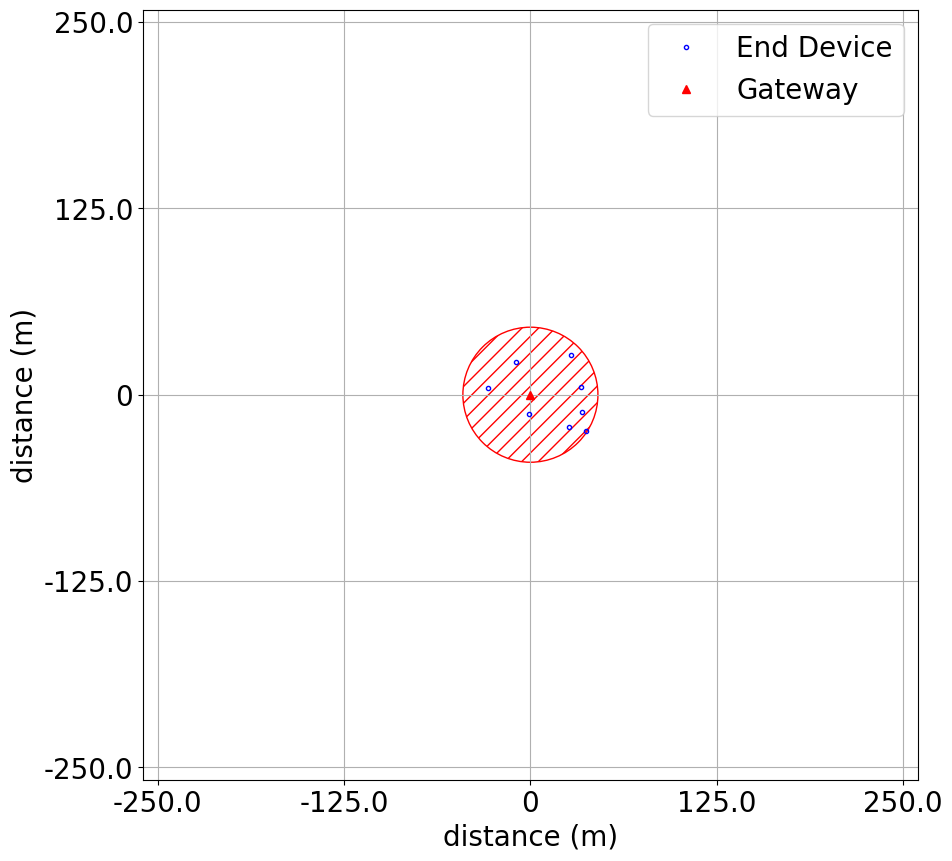

Thresholds for SF7, SF8, SF9, SF10:  [0 1 2 2]
Thresholds for SF11, SF12:  [0 1 2 3]


In [ ]:
#Initialize env and Q-table
seed=18
n_agents = 8
n_threshold = 4
max_steps = 1000
env = LoRaNetwork(max_steps=max_steps, n_agents=n_agents, n_threshold=n_threshold, loc_range = bestDist)
env.reset(seed=seed)
plotLocations(env.bsList, env.agents)
print("Thresholds for SF7, SF8, SF9, SF10: ", env.arr_thresholds)
print("Thresholds for SF11, SF12: ", env.arr_thresholds_high)

In [ ]:
'''[0,0] 0*1+0*3 = 0
[0,1] 0*1+1*3 = 3
[1,0] 1
[1,1] 4
[0,2] 6
[1,2] 7
[2,0] 2
[2,2] 8
[2,1] 5'''

'[0,0] 0*1+0*3 = 0\n[0,1] 0*1+1*3 = 3\n[1,0] 1\n[1,1] 4\n[0,2] 6\n[1,2] 7\n[2,0] 2\n[2,2] 8\n[2,1] 5'

In [ ]:
Q = np.ones((env.n_agents, n_threshold**6, 6))

In [ ]:
#Q[i, state_idx, action[i]] + lr * (reward + discount_factor * np.max(Q[i, new_state_idx, :]) - Q[i, state_idx, action[i]])

In [ ]:
#Training the agent

#Creating lists to keep track of reward and epsilon values
training_rewards = []
epsilons = []
lrs = []
pdrs = []
visited_states = np.zeros(n_threshold**6)

for episode in range(train_episodes):
    #Reseting the environment each time as per requirement
    state = env.reset(seed=seed)
    state_idx = get_state_idx(state)
    visited_states[state_idx] = 1
    action_count = np.zeros(6)
    #Starting the tracker for the rewards
    total_training_rewards = 0
    lr = step_decay(episode, initial_lr)
    exp_exp_tradeoff = np.random.uniform(0, 1, size = [max_steps, n_agents])
    for step in range(max_steps):
        #Choosing an action given the states based on a random number
        #exp_exp_tradeoff = np.random.uniform(0, 1, size = n_agents)
        idx = np.argwhere(exp_exp_tradeoff[step] > epsilon)
        action = env.action_space.sample()
        #print("action sampled ", action)
        #print("non-random idx", idx)
        ### STEP 2: SECOND option for choosing the initial action - exploit
        #If the random number is larger than epsilon: employing exploitation
        #and selecting best action
        action[idx] = Q[idx,state_idx,:].argmax(-1)
        #print("Final actions  ", action)
        action_count += np.bincount(action, minlength=6)


        ### STEPs 3 & 4: performing the action and getting the reward
        #Taking the action and getting the reward and outcome state
        new_state, reward, done, info = env.step(action)
        new_state_idx = get_state_idx(new_state)

        ### STEP 5: update the Q-table
        #Updating the Q-table using the Bellman equation
        for i in range(env.n_agents):
            Q[i, state_idx, action[i]] = Q[i, state_idx, action[i]] + lr * (reward[i] + discount_factor * np.max(Q[i, new_state_idx, :]) - Q[i, state_idx, action[i]])
        #Increasing our total reward and updating the state
        total_training_rewards += reward
        state = new_state
        state_idx = new_state_idx
        visited_states[state_idx] = 1

    #print ("[eps={:.3f}, lr={:.4f} {}, vs={:.2f}%, action_count = {}, avg_pdr = {:.2f}] Total reward for episode {}: {:.3f}".format(epsilon, lr, state, 100*visited_states.mean(), action_count/action_count.sum()*100, info, episode, total_training_rewards))
    #Cutting down on exploration by reducing the epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

    #Adding the total reward and reduced epsilon values
    pdrs.append(info)
    training_rewards.append(total_training_rewards)
    epsilons.append(epsilon)
    lrs.append(lr)



print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

Training score over time: [886.74291529 881.78473785 883.92205142 887.72174305 885.6185647
 883.19763435 882.07839947 876.55425788]


In [ ]:
filename="/content/drive/MyDrive/Colab Data/comp_q_table_"+"n"+str(env.n_agents)+"_t"+str(env._n_threshold)
np.save(filename,Q)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filename="/content/drive/MyDrive/Colab Data/comp_pdr_"+"n"+str(env.n_agents)+"_t"+str(env._n_threshold)
np.save(filename,Q)

Node ID: 00  SF: 07   packets sent:  987  packets received:  882  PDR:'0.89'
Node ID: 01  SF: 07   packets sent:  991  packets received:  886  PDR:'0.89'
Node ID: 02  SF: 10   packets sent:  992  packets received:  893  PDR:'0.90'
Node ID: 03  SF: 08   packets sent:  995  packets received:  887  PDR:'0.89'
Node ID: 04  SF: 07   packets sent:  992  packets received:  887  PDR:'0.89'
Node ID: 05  SF: 07   packets sent:  990  packets received:  881  PDR:'0.89'
Node ID: 06  SF: 07   packets sent:  991  packets received:  888  PDR:'0.90'
Node ID: 07  SF: 08   packets sent:  988  packets received:  882  PDR:'0.89'
Node ID: 08  SF: 08   packets sent:  993  packets received:  891  PDR:'0.90'
Node ID: 09  SF: 09   packets sent:  990  packets received:  877  PDR:'0.89'
Node ID: 10  SF: 07   packets sent:  992  packets received:  893  PDR:'0.90'
Node ID: 11  SF: 08   packets sent:  989  packets received:  881  PDR:'0.89'
Node ID: 12  SF: 08   packets sent:  990  packets received:  887  PDR:'0.90'

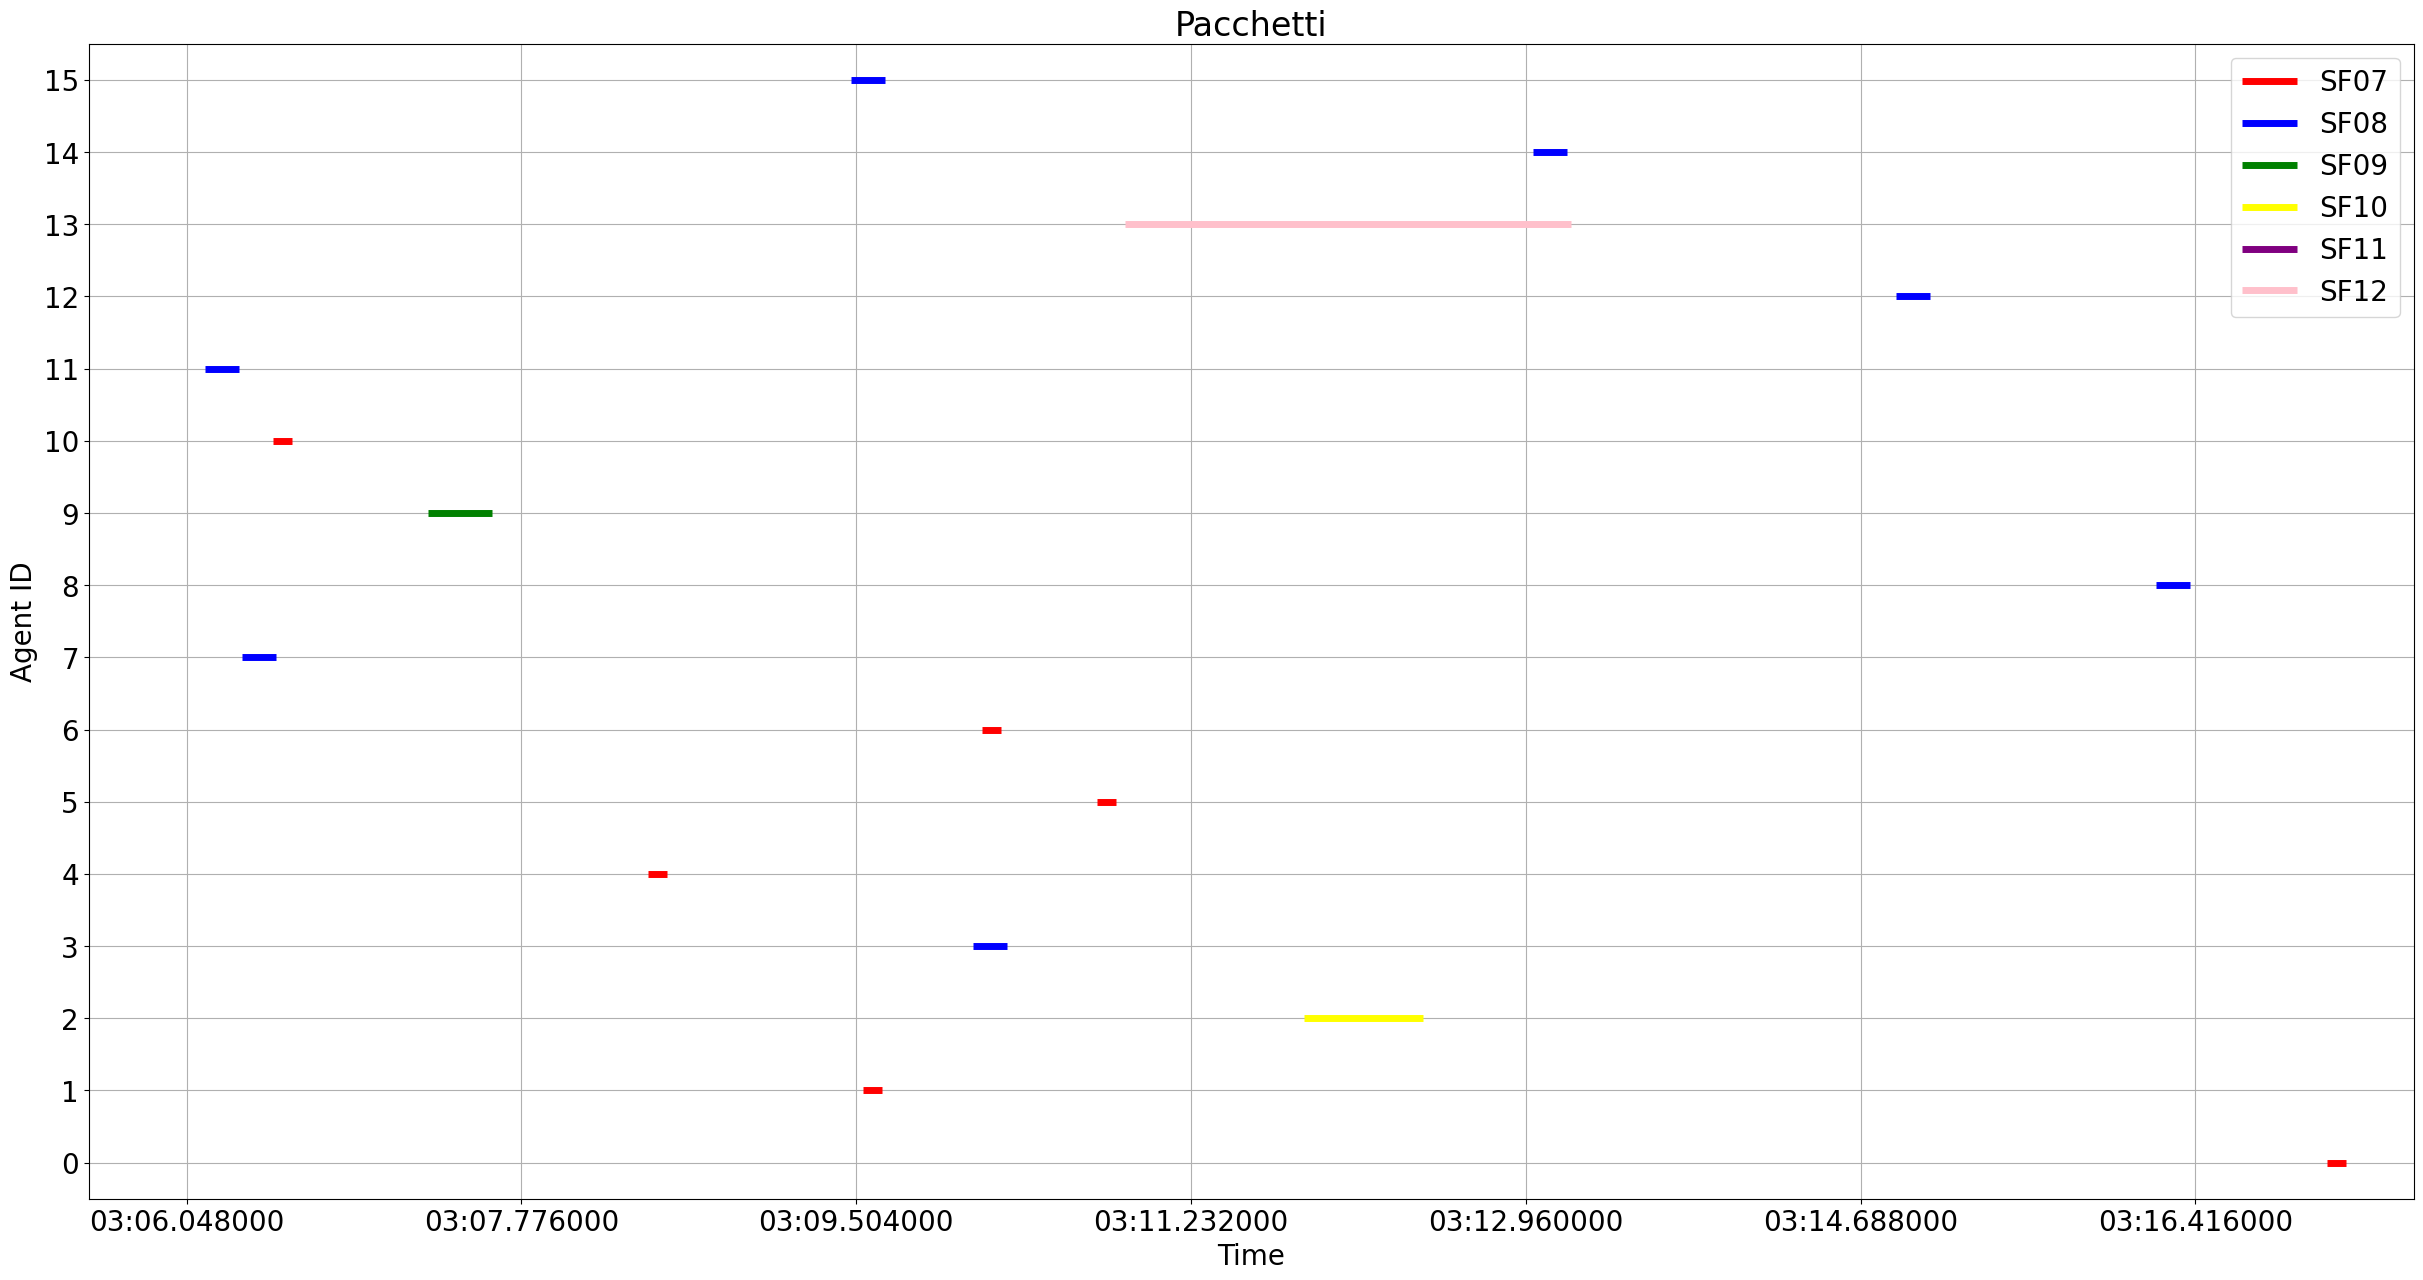

Average PDR: 0.89


In [ ]:
env.render(plot=True)

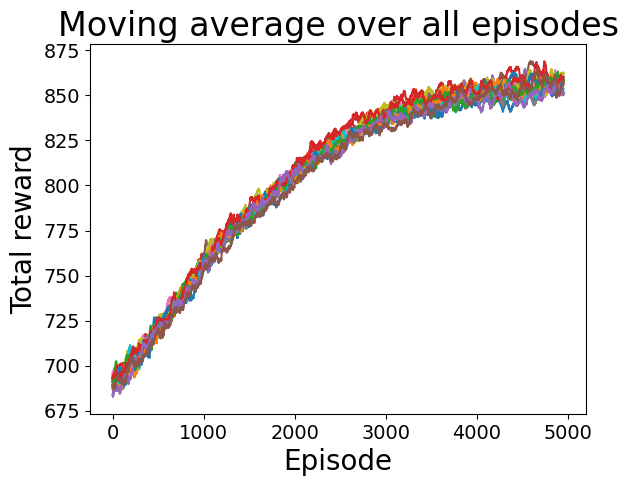

In [ ]:
ma = []
window = 50
for i in range(len(training_rewards)-window):
  ma.append(sum(training_rewards[i:i+window])/window)
x = range(len(ma))
plt.plot(x, ma)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Moving average over all episodes')
plt.show()

In [ ]:
seed = range(20)
env = LoRaNetwork(max_steps=max_steps, n_agents=n_agents, n_threshold=n_threshold, loc_range = bestDist)

In [ ]:
state = env.reset(seed=seed)
action = env.n_agents*[5]
for step in range(max_steps):
  state, reward, _, _ = env.step(action)
  #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
env.render()

Node ID: 00  SF: 12   packets sent:  987  packets received:  26  PDR:'0.03'
Node ID: 01  SF: 12   packets sent:  991  packets received:  35  PDR:'0.04'
Node ID: 02  SF: 12   packets sent:  992  packets received:  21  PDR:'0.02'
Node ID: 03  SF: 12   packets sent:  995  packets received:  26  PDR:'0.03'
Node ID: 04  SF: 12   packets sent:  992  packets received:  27  PDR:'0.03'
Node ID: 05  SF: 12   packets sent:  990  packets received:  18  PDR:'0.02'
Node ID: 06  SF: 12   packets sent:  991  packets received:  19  PDR:'0.02'
Node ID: 07  SF: 12   packets sent:  988  packets received:  22  PDR:'0.02'
Node ID: 08  SF: 12   packets sent:  993  packets received:  33  PDR:'0.03'
Node ID: 09  SF: 12   packets sent:  990  packets received:  35  PDR:'0.04'
Node ID: 10  SF: 12   packets sent:  992  packets received:  23  PDR:'0.02'
Node ID: 11  SF: 12   packets sent:  989  packets received:  22  PDR:'0.02'
Node ID: 12  SF: 12   packets sent:  990  packets received:  26  PDR:'0.03'
Node ID: 13 

In [ ]:
state = env.reset(seed=seed)
action = env.n_agents*[0]
for step in range(max_steps):
  state, reward, _, _ = env.step(action)
  #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
env.render()

Node ID: 00  SF: 07   packets sent:  987  packets received:  786  PDR:'0.80'
Node ID: 01  SF: 07   packets sent:  991  packets received:  755  PDR:'0.76'
Node ID: 02  SF: 07   packets sent:  992  packets received:  792  PDR:'0.80'
Node ID: 03  SF: 07   packets sent:  995  packets received:  788  PDR:'0.79'
Node ID: 04  SF: 07   packets sent:  992  packets received:  834  PDR:'0.84'
Node ID: 05  SF: 07   packets sent:  990  packets received:  802  PDR:'0.81'
Node ID: 06  SF: 07   packets sent:  991  packets received:  783  PDR:'0.79'
Node ID: 07  SF: 07   packets sent:  988  packets received:  775  PDR:'0.78'
Node ID: 08  SF: 07   packets sent:  993  packets received:  796  PDR:'0.80'
Node ID: 09  SF: 07   packets sent:  990  packets received:  801  PDR:'0.81'
Node ID: 10  SF: 07   packets sent:  992  packets received:  797  PDR:'0.80'
Node ID: 11  SF: 07   packets sent:  989  packets received:  792  PDR:'0.80'
Node ID: 12  SF: 07   packets sent:  990  packets received:  797  PDR:'0.81'

In [ ]:
state = env.reset(seed=seed)
for step in range(max_steps):
  action = env.action_space.sample()
  state, reward, _, _ = env.step(action)
  #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
env.render()

Node ID: 00  SF: 07   packets sent:  987  packets received:  767  PDR:'0.78'
Node ID: 01  SF: 07   packets sent:  991  packets received:  765  PDR:'0.77'
Node ID: 02  SF: 08   packets sent:  992  packets received:  758  PDR:'0.76'
Node ID: 03  SF: 12   packets sent:  995  packets received:  755  PDR:'0.76'
Node ID: 04  SF: 11   packets sent:  992  packets received:  757  PDR:'0.76'
Node ID: 05  SF: 11   packets sent:  990  packets received:  774  PDR:'0.78'
Node ID: 06  SF: 10   packets sent:  991  packets received:  756  PDR:'0.76'
Node ID: 07  SF: 07   packets sent:  988  packets received:  760  PDR:'0.77'
Node ID: 08  SF: 09   packets sent:  993  packets received:  778  PDR:'0.78'
Node ID: 09  SF: 08   packets sent:  990  packets received:  784  PDR:'0.79'
Node ID: 10  SF: 12   packets sent:  992  packets received:  790  PDR:'0.80'
Node ID: 11  SF: 08   packets sent:  989  packets received:  774  PDR:'0.78'
Node ID: 12  SF: 07   packets sent:  990  packets received:  775  PDR:'0.78'

In [ ]:
#Smart
pdr = []
toa = []
del_f = []
for s in seed:
  state = env.reset(seed=s)
  n_use = np.zeros(6)
  for step in range(max_steps):
    state_idx = get_state_idx(state)
    action = Q[:,state_idx,:].argmax(-1)
    n_use += np.bincount(action, minlength=6)
    #%lprun  -f env.transmit  state, reward, _, _ = env.step(action)
    state, reward, done, info = env.step(action)
    #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
  #env.render()
  pdr.append(info['pdr'])
  toa.append(info['avg_airtime'])
  del_f.append(info['del_factor'])
pdr_smart = sum(pdr)/len(pdr)
avg_toa_smart = sum(toa)/len(toa)
delf_smart = sum(del_f)/len(del_f)
print(pdr_smart)
print(avg_toa_smart)
print(n_use)
print(n_use.sum())

0.9253105638800664
125.95039999999999
[5.000e+03 2.999e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00]
8000.0


In [ ]:
pdr_smart - env.beta*(avg_toa_smart-env.min_air_time)/(env.max_air_time-env.min_air_time)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.922088123106637

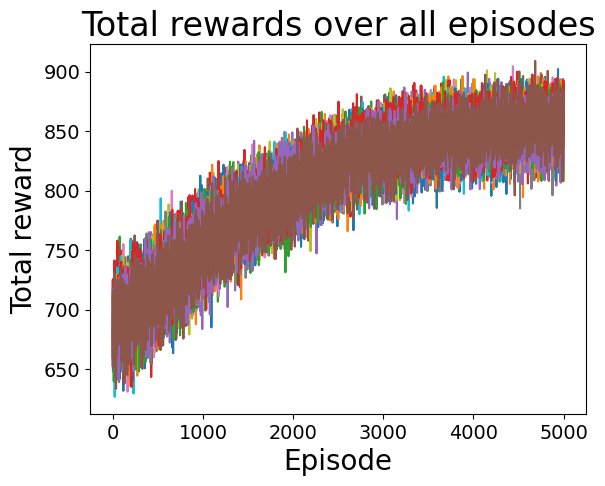

In [ ]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Total rewards over all episodes')
plt.show()

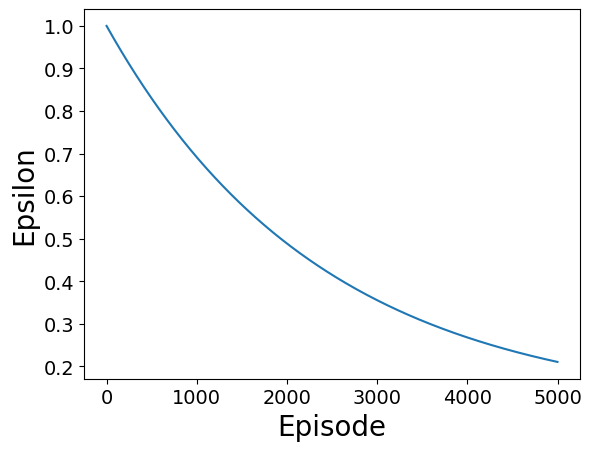

In [ ]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
#plt.title("Epsilon for episode")
plt.show()

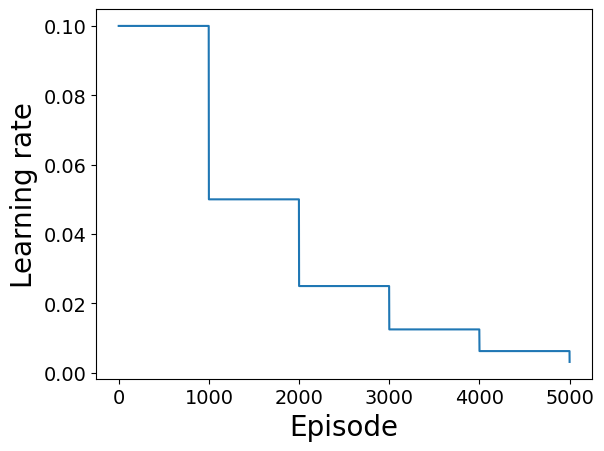

In [ ]:
#Visualizing the epsilons over all episodes
plt.plot(lrs)
plt.xlabel('Episode')
plt.ylabel('Learning rate')
#plt.title("Learning rate for episode")
plt.show()

[61.9875 23.025   4.375   3.225   3.5     3.8875]


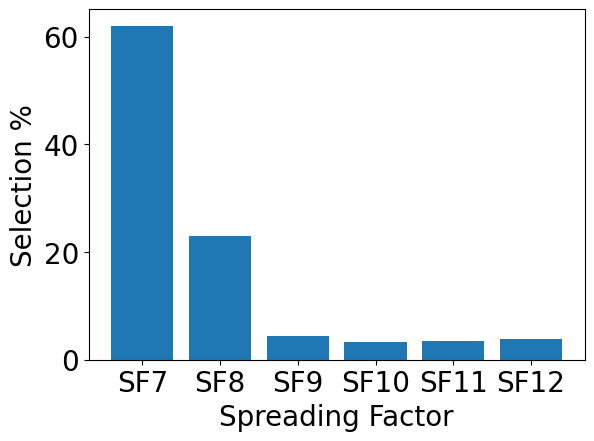

In [ ]:
y = np.arange(6)
print(action_count/action_count.sum()*100)
sf = ['SF7','SF8','SF9','SF10','SF11','SF12']
plt.figure()
plt.subplots_adjust(bottom=0.15)
plt.bar(y, action_count/action_count.sum()*100)
plt.xticks(y,sf)
plt.xlabel("Spreading Factor")
plt.ylabel("Selection %")
plt.savefig('my_plot.png')